# Currency exchange rate trends analyzer

### Trend analysis for EURPLN exchange rates using data from 2013.09.09 to 2016.09.05 time period

In [18]:
# customarilily import most important libraries

import pandas as pd                       # pandas is a dataframe library
import matplotlib.pyplot as plt           # matplotlib.pyplot plots data
import numpy as np                        # numpy provides N-dim object support

# do ploting inline instead of in a separate window
%matplotlib inline

In [19]:
df = pd.read_csv('./data-archive/EUR_2013.09.09_2016.09.05.csv', sep=';')     # load data

In [20]:
# get brief statistics over data we just read
df_columns, df_rows = df.shape

print("File contains {} rows and {} columns of data.".format(df_columns, df_rows))

File contains 755 rows and 4 columns of data.


#### Show first 5 rows from file

In [21]:
df.head(5)

,Data,Kurs,Zmiana,Nazwa Tabeli
0,2016-09-05,4.3480,-0.72,171/A/NBP/2016
1,2016-09-02,4.3796,0.43,170/A/NBP/2016
2,2016-09-01,4.3607,0.12,169/A/NBP/2016
3,2016-08-31,4.3555,0.37,168/A/NBP/2016
4,2016-08-30,4.3395,0.00,167/A/NBP/2016


#### Show last 5 rows from file

In [22]:
df.tail(5)

,Data,Kurs,Zmiana,Nazwa Tabeli
750,2013-09-13,4.2110,-0.30,178/A/NBP/2013
751,2013-09-12,4.2238,-0.40,177/A/NBP/2013
752,2013-09-11,4.2408,-0.54,176/A/NBP/2013
753,2013-09-10,4.2637,-0.15,175/A/NBP/2013
754,2013-09-09,4.2700,-0.64,174/A/NBP/2013


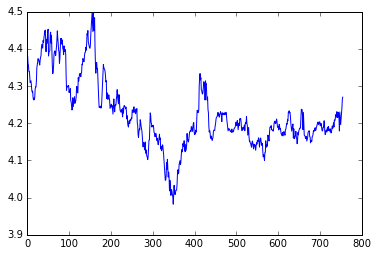

In [23]:
exchange_rates = df['Kurs'].values
plt.plot(exchange_rates)

In [24]:
# TODO: fix problem - data are not ordered chronologically